In [ ]:
!pip install pytube

In [ ]:
!pip install youtube-transcript-api

#Step 1: Video library (10 points)
Write a python API that will download the video and its closed captions from youtube. Make sure to document how one can use your API. Use this to download the following videos from youtube along with their captions:

In [ ]:
import os
from pytube import YouTube
from youtube_transcript_api import YouTubeTranscriptApi

def download_video(link, output_path='.'):
    """
    Download a YouTube video from the provided link.

    Args:
    - link (str): The URL of the YouTube video.
    - output_path (str): The path where the video will be saved. Default is the current directory.
    """
    try:
        youtube_object = YouTube(link)
        video_stream = youtube_object.streams.get_highest_resolution()
        video_title = youtube_object.title
        output_file = video_stream.download(output_path)
        new_filename = os.path.join(output_path, f"{video_title}.mp4")
        os.rename(output_file, new_filename)
        print(f"Download completed successfully for: {link}")
    except Exception as e:
        print(f"An error occurred while downloading the video for {link}: {str(e)}")

def download_captions(video_id, output_path='.'):
    """
    Download closed captions for a YouTube video.

    Args:
    - video_id (str): The ID of the YouTube video.
    - output_path (str): The path where the captions will be saved. Default is the current directory.
    """
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        captions_file = os.path.join(output_path, f"{video_id}_captions.txt")
        with open(captions_file, "w", encoding='utf-8') as f:
            for segment in transcript:
                f.write(f"{segment['text']}\n")
        print(f"Captions downloaded successfully for video ID: {video_id}")
    except Exception as e:
        print(f"An error occurred while downloading captions for video ID {video_id}: {str(e)}")

def extract_video_id(link):
    """
    Extract the video ID from a YouTube link.

    Args:
    - link (str): The URL of the YouTube video.

    Returns:
    - str: The video ID.
    """
    try:
        return link.split("v=")[1].split("&")[0]
    except IndexError:
        raise ValueError("Invalid YouTube URL format")

def download_video_and_captions(video_links, output_path='.'):
    """
    Download both the video and its closed captions from YouTube.

    Args:
    - video_links (list): List of YouTube video URLs.
    - output_path (str): The path where the videos and captions will be saved. Default is the current directory.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for link in video_links:
        try:
            video_id = extract_video_id(link)
            download_video(link, output_path)
            download_captions(video_id, output_path)
        except Exception as e:
            print(f"An error occurred with the video link {link}: {str(e)}")

video_links = [
    'https://www.youtube.com/watch?v=wbWRWeVe1XE',
    'https://www.youtube.com/watch?v=FlJoBhLnqko',
    'https://www.youtube.com/watch?v=Y-bVwPRy_no'
]

output_path = '/content/downloads'
download_video_and_captions(video_links, output_path)

for root, dirs, files in os.walk(output_path):
    for file in files:
        print(os.path.join(root, file))


Download completed successfully for: https://www.youtube.com/watch?v=wbWRWeVe1XE
Captions downloaded successfully for video ID: wbWRWeVe1XE
Download completed successfully for: https://www.youtube.com/watch?v=FlJoBhLnqko
Captions downloaded successfully for video ID: FlJoBhLnqko
Download completed successfully for: https://www.youtube.com/watch?v=Y-bVwPRy_no
Captions downloaded successfully for video ID: Y-bVwPRy_no
/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
/content/downloads/How Green Roofs Can Help Cities | NPR.mp4
/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4
/content/downloads/wbWRWeVe1XE_captions.txt
/content/downloads/FlJoBhLnqko_captions.txt
/content/downloads/Y-bVwPRy_no_captions.txt


#Preprocess the video (15 points)
You can use opencv, ffmpeg, gstreameer, https://pytorchvideo.org/ or any other library to implement the preprocessing steps as shown below:


In [ ]:
import cv2  # OpenCV library for image and video processing
import numpy as np
from tqdm import tqdm  # Used for progress bars during frame processing
import os

def preprocess_video(video_path, output_filename, num_frames=32, resize=(224, 224)):
    """
    Preprocess a video: decode frames, sample frames, resize, scale, normalize, and save as .npy.

    Args:
    - video_path (str): Path to the input video file.
    - output_filename (str): Filename for the output .npy file.
    - num_frames (int): Number of frames to sample from the video. (default is 32).
    - resize (tuple): Target size for resizing frames (width, height). (default is (224, 224)).

    Returns:
    - frames (np.ndarray): Processed frames stacked in a numpy array.
    """
    cap = cv2.VideoCapture(video_path)  # Open video capture object
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames in the video
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)  # Generate evenly spaced frame indices to sample from

    frames = []
    for idx in tqdm(frame_indices, desc=f"Processing {os.path.basename(video_path)}"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Set frame position
        ret, frame = cap.read()  # Read frame
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = cv2.resize(frame, resize)  # Resize frame to specified dimensions
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
            frames.append(frame)
        else:
            print(f"Warning: Could not read frame at index {idx} from video {video_path}")

    cap.release()  # Release video capture object
    if len(frames) < num_frames:
        print(f"Warning: Not enough frames were read from {video_path}. Expected {num_frames}, got {len(frames)}.")

    frames = np.stack(frames) if frames else np.empty((0, *resize, 3))  # Handle case when no frames are read
    np.save(output_filename, frames)  # Save processed frames as .npy file
    print(f"Processed frames saved to {output_filename}")

    return frames

# List of video paths and corresponding output filenames
video_paths = [
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4",
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4"
]

output_filenames = [
    '/content/downloads/green_roofs_frames.npy',
    '/content/downloads/preschool_frames.npy',
    '/content/downloads/hotter_city_frames.npy'
]

# Ensure output directories exist
for output_filename in output_filenames:
    output_dir = os.path.dirname(output_filename)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

# Process each video and save frames
for video_path, output_filename in zip(video_paths, output_filenames):
    preprocess_video(video_path, output_filename)


Processing Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 49.01it/s]


Processed frames saved to /content/downloads/green_roofs_frames.npy


Processing How Green Roofs Can Help Cities | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 56.52it/s]


Processed frames saved to /content/downloads/preschool_frames.npy


Processing What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4: 100%|██████████| 32/32 [00:00<00:00, 44.62it/s]

Processed frames saved to /content/downloads/hotter_city_frames.npy


Displaying frames from: /content/downloads/green_roofs_frames.npy
Number of frames in /content/downloads/green_roofs_frames.npy: 32


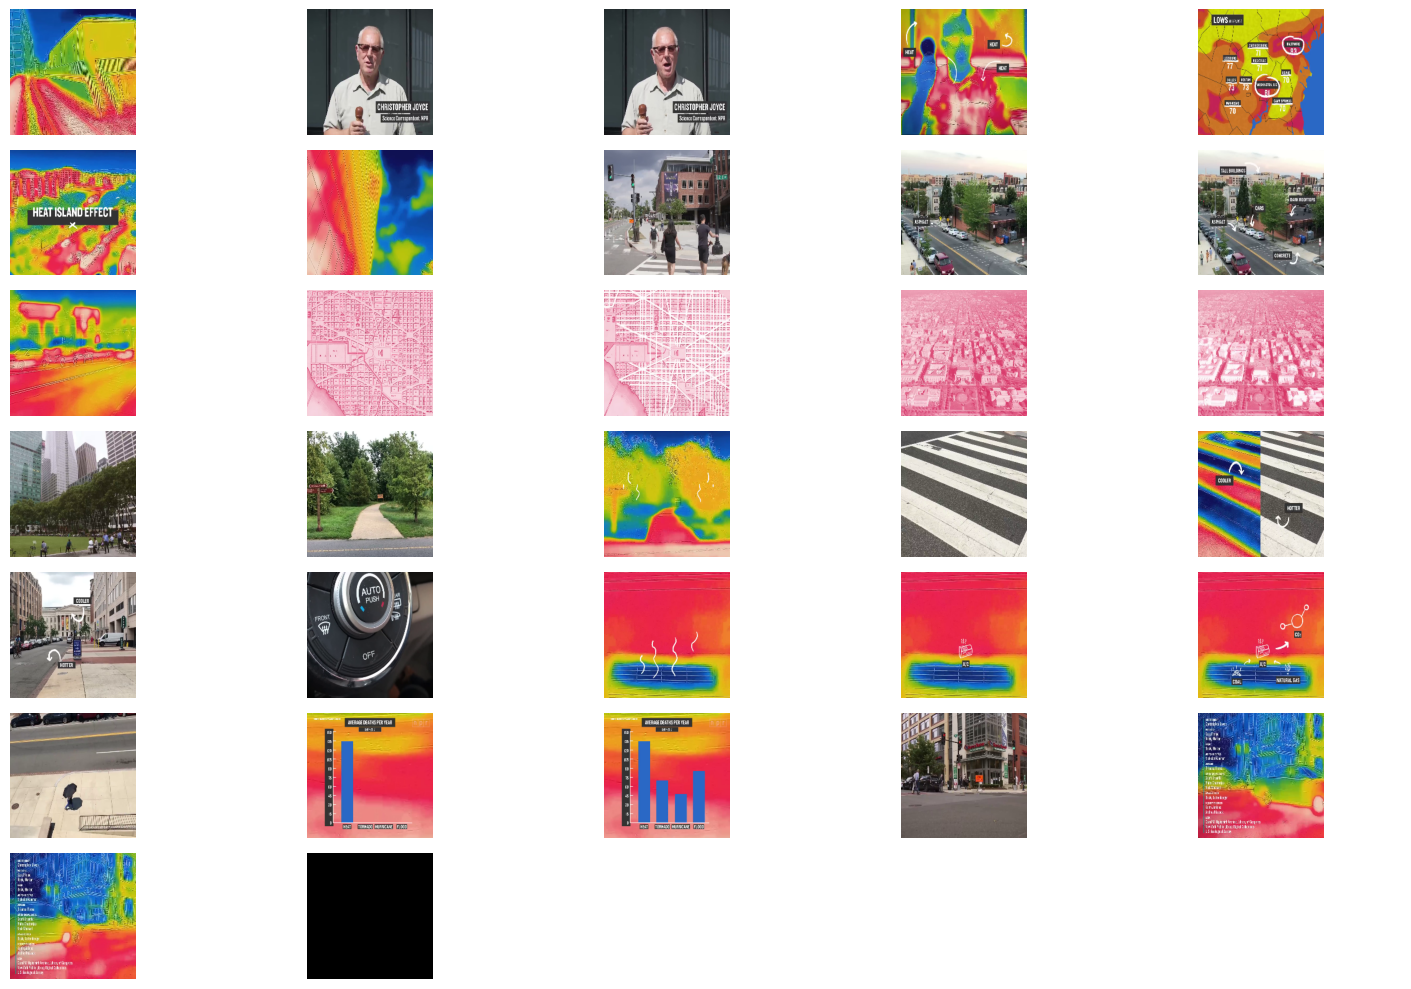

Displaying frames from: /content/downloads/preschool_frames.npy
Number of frames in /content/downloads/preschool_frames.npy: 32


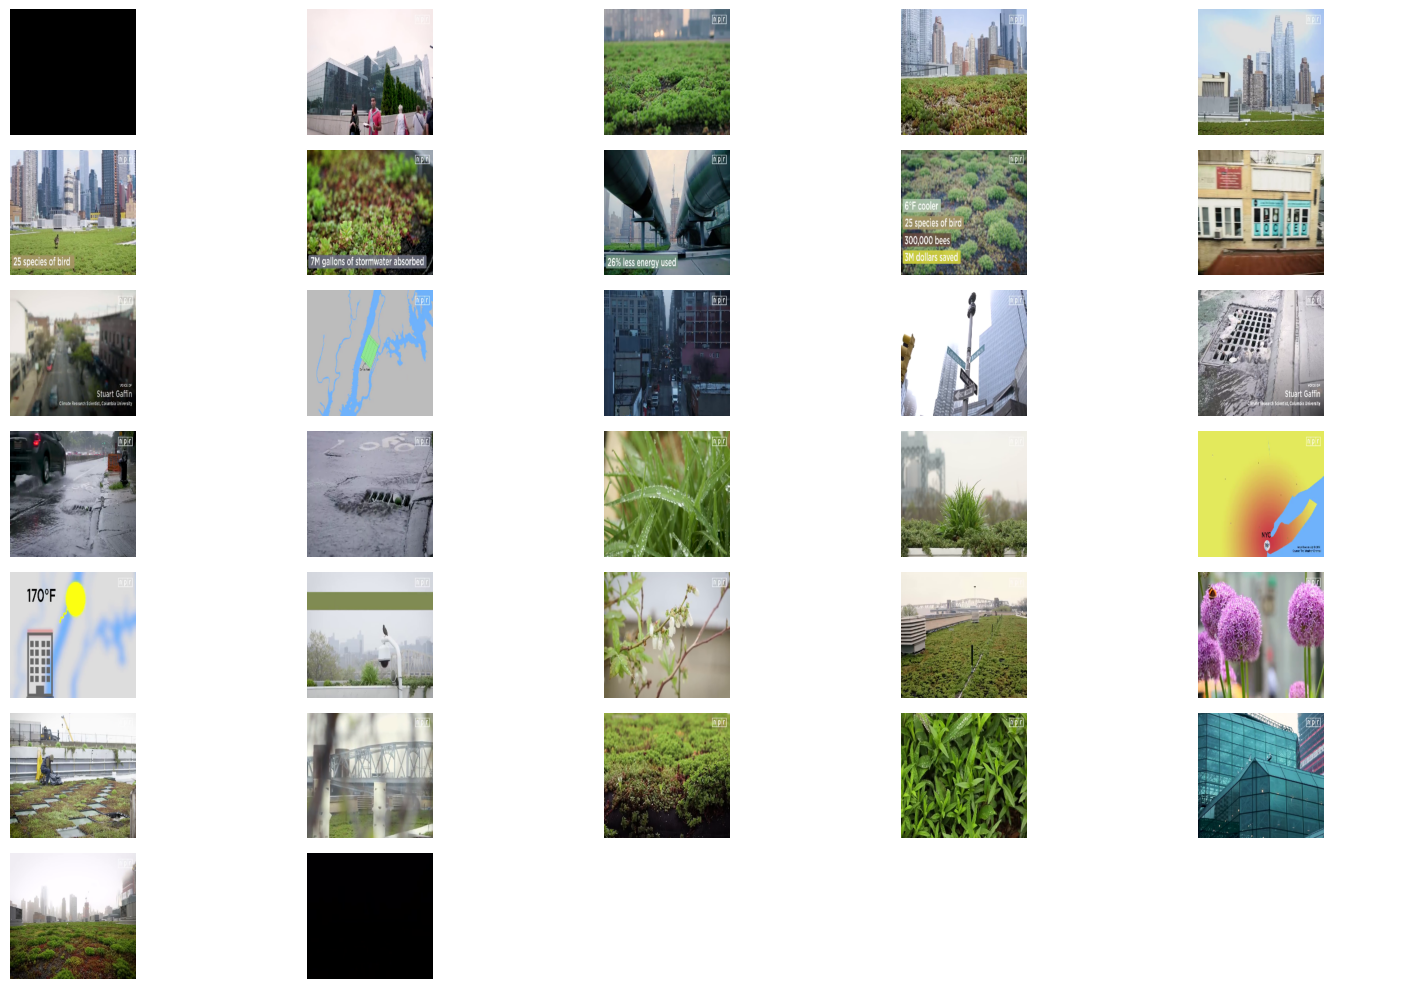

Displaying frames from: /content/downloads/hotter_city_frames.npy
Number of frames in /content/downloads/hotter_city_frames.npy: 32


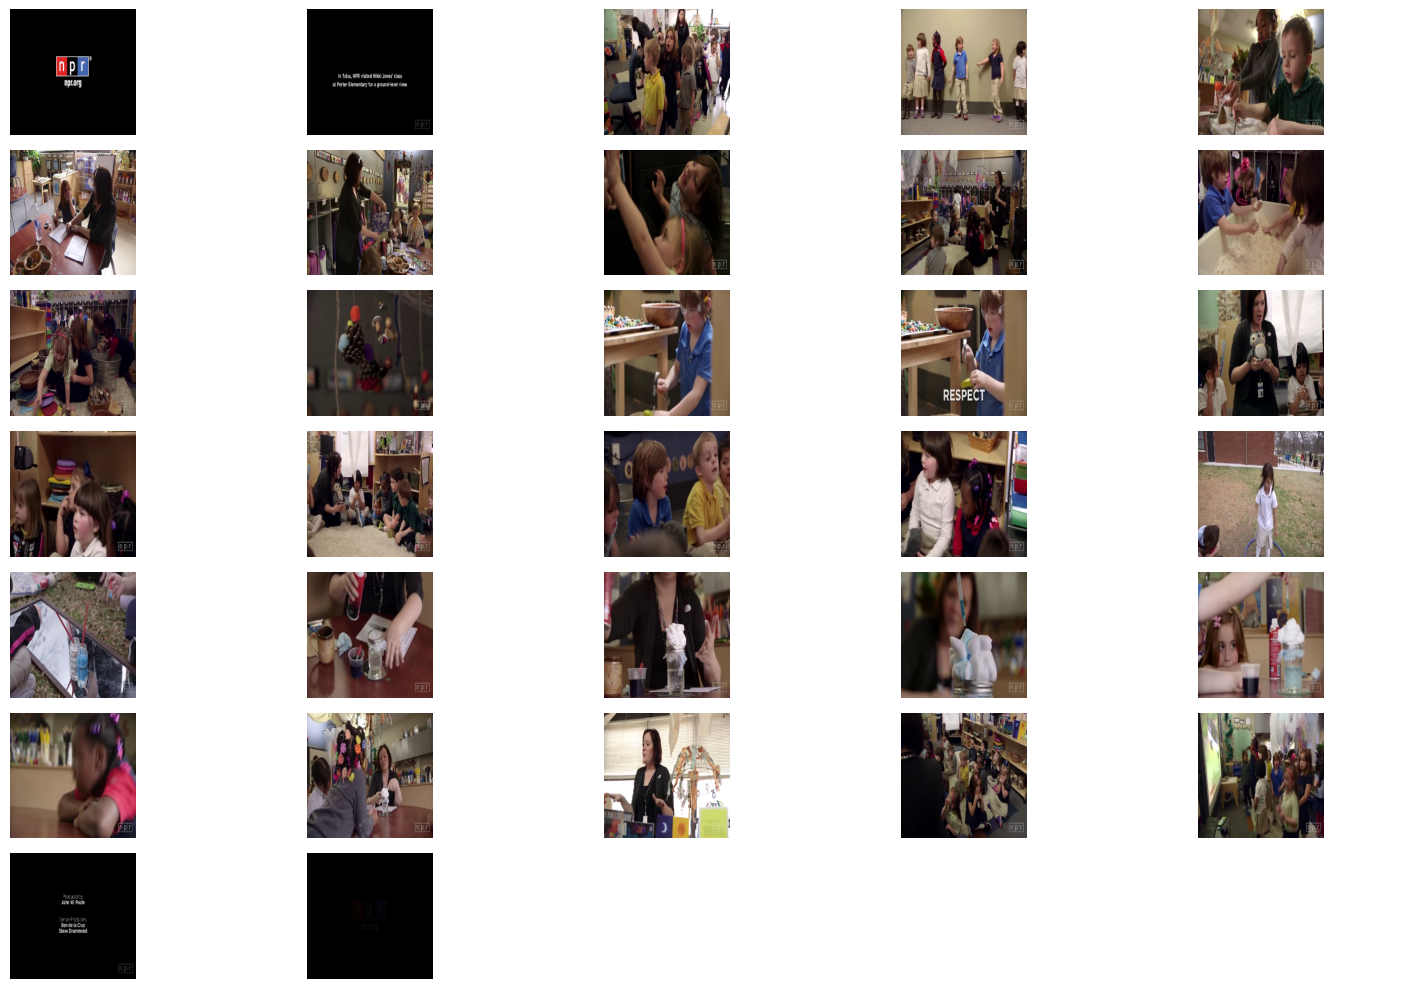

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to load and display frames from .npy file
def display_frames_from_npy(npy_file):
    frames = np.load(npy_file)
    num_frames = frames.shape[0]
    print(f"Number of frames in {npy_file}: {num_frames}")

    # Dynamically adjust the subplot layout
    cols = min(num_frames, 5)  # Show up to 5 frames per row
    rows = (num_frames + cols - 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten() if num_frames > 1 else [axes]

    for i in range(num_frames):
        axes[i].imshow(frames[i])
        axes[i].axis('off')

    for j in range(num_frames, len(axes)):  # Hide any extra subplots
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage to display frames from each .npy file
npy_files = [
    '/content/downloads/green_roofs_frames.npy',
    '/content/downloads/preschool_frames.npy',
    '/content/downloads/hotter_city_frames.npy'
]

for npy_file in npy_files:
    print(f"Displaying frames from: {npy_file}")
    display_frames_from_npy(npy_file)


#Detecting objects (25 points)
Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes. For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]

In [ ]:
import cv2
import torch
import pandas as pd
import numpy as np
from datetime import timedelta
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# List of video paths
video_paths = [
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4",
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4"
]
results = []

# Process each video
for vidId, video_path in enumerate(video_paths):
    logging.info(f"Processing video {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Error: Could not open video {video_path}")
        continue

    frame_num = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logging.info(f"Total frames: {total_frames}, FPS: {fps}")

    frame_interval = 10  # Process every 10th frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % frame_interval == 0:
            logging.info(f"Processing frame {frame_num}/{total_frames}")
            timestamp = str(timedelta(seconds=frame_num / fps))

            results_yolo = model(frame)
            detections = results_yolo.pandas().xyxy[0]

            for _, detection in detections.iterrows():
                detectedObjId = detection['class']
                detectedObjClass = detection['name']
                confidence = detection['confidence']
                bbox_info = [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']]

                results.append([
                    vidId, frame_num, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, video_path  # Include video_path
                ])

        frame_num += 1

    cap.release()
    logging.info(f"Finished processing video {video_path}")

# Save results to CSV
df = pd.DataFrame(results, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox info', 'video_path'])
df.to_csv('detection_results.csv', index=False)
logging.info("Detection results saved to detection_results.csv")


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 237.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 237.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 7.5s, installed 3 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-6-21 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 227MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
WARNING ⚠️ NMS time limit 0.550s exceeded


#2.3 Embedding model (30 points)
Develop a convolutional autoencoder such as the one described here whose input will be all the objects detected in each frame (not the entire frame!), if any. Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it’s small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.

#Step 1: Extract Detected Objects
First, we need to crop the detected objects from the video frames and resize them to a consistent size.

In [ ]:
import cv2
import torch
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# List of video paths
video_paths = [
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
]

results = []
cropped_objects = []

# Ensure output directories exist
cropped_objects_dir = '/content/cropped_objects'
os.makedirs(cropped_objects_dir, exist_ok=True)

# Process each video
for vidId, video_path in enumerate(video_paths):
    logging.info(f"Processing video {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Error: Could not open video {video_path}")
        continue

    frame_num = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logging.info(f"Total frames: {total_frames}, FPS: {fps}")

    frame_interval = 10  # Process every 10th frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % frame_interval == 0:
            logging.info(f"Processing frame {frame_num}/{total_frames}")
            timestamp = str(timedelta(seconds=frame_num / fps))

            results_yolo = model(frame)
            detections = results_yolo.pandas().xyxy[0]

            for _, detection in detections.iterrows():
                detectedObjId = detection['class']
                detectedObjClass = detection['name']
                confidence = detection['confidence']
                bbox_info = [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']]

                # Extract and save the detected object
                xmin, ymin, xmax, ymax = map(int, [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']])
                cropped_obj = frame[ymin:ymax, xmin:xmax]
                cropped_obj_resized = cv2.resize(cropped_obj, (64, 64))  # Resize to a consistent shape
                obj_filename = f"{cropped_objects_dir}/video{vidId}_frame{frame_num}_obj{detectedObjId}.jpg"
                cv2.imwrite(obj_filename, cropped_obj_resized)
                cropped_objects.append(cropped_obj_resized)

                results.append([
                    vidId, frame_num, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, video_path, obj_filename  # Include video_path and obj_filename
                ])

        frame_num += 1

    cap.release()
    logging.info(f"Finished processing video {video_path}")

# Save results to CSV
df = pd.DataFrame(results, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox info', 'video_path', 'obj_filename'])
df.to_csv('detection_results.csv', index=False)
logging.info("Detection results saved to detection_results.csv")

# Convert cropped_objects to a numpy array
cropped_objects = np.array(cropped_objects)
cropped_objects = cropped_objects.astype('float32') / 255.0
cropped_objects = np.reshape(cropped_objects, (len(cropped_objects), 64, 64, 3))


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-21 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


#Step 2: Define the Autoencoder


In [ ]:
import keras
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define input shape
input_img = keras.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01))(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01))(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

# Compile the autoencoder with Adam optimizer and binary cross-entropy loss
adam_optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=adam_optimizer, loss='binary_crossentropy')

# Assuming cropped_objects, x_train, and x_val are defined
# Split the data into training and validation sets
split_idx = int(0.8 * len(cropped_objects))
x_train = cropped_objects[:split_idx]
x_val = cropped_objects[split_idx:]

# Define the learning rate scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

# Train the autoencoder with regularization
history = autoencoder.fit(x_train, x_train,
                          epochs=200,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(x_val, x_val),
                          callbacks=[lr_scheduler])

# Evaluate and monitor using PSNR
from skimage.metrics import peak_signal_noise_ratio
decoded_imgs = autoencoder.predict(x_val)
psnr = peak_signal_noise_ratio(x_val, decoded_imgs)
print("PSNR:", psnr)

Epoch 1/200
77/77 [==============================] - 10s 29ms/step - loss: 1.3687 - val_loss: 1.3089 - lr: 1.0000e-04
Epoch 2/200
77/77 [==============================] - 1s 12ms/step - loss: 1.2231 - val_loss: 1.2407 - lr: 1.0000e-04
Epoch 3/200
77/77 [==============================] - 1s 12ms/step - loss: 1.1428 - val_loss: 1.1644 - lr: 1.0000e-04
Epoch 4/200
77/77 [==============================] - 1s 12ms/step - loss: 1.0766 - val_loss: 1.0845 - lr: 1.0000e-04
Epoch 5/200
77/77 [==============================] - 1s 12ms/step - loss: 1.0168 - val_loss: 1.0120 - lr: 1.0000e-04
Epoch 6/200
77/77 [==============================] - 1s 12ms/step - loss: 0.9625 - val_loss: 0.9512 - lr: 1.0000e-04
Epoch 7/200
77/77 [==============================] - 1s 11ms/step - loss: 0.9128 - val_loss: 0.8990 - lr: 1.0000e-04
Epoch 8/200
77/77 [==============================] - 1s 12ms/step - loss: 0.8673 - val_loss: 0.8555 - lr: 1.0000e-04
Epoch 9/200
77/77 [==============================] - 1s 12ms/st

In [47]:
print(history.history.keys())

dict_keys(['loss', 'val_loss', 'lr'])


#with lr=0.001

#with lr=0.0001

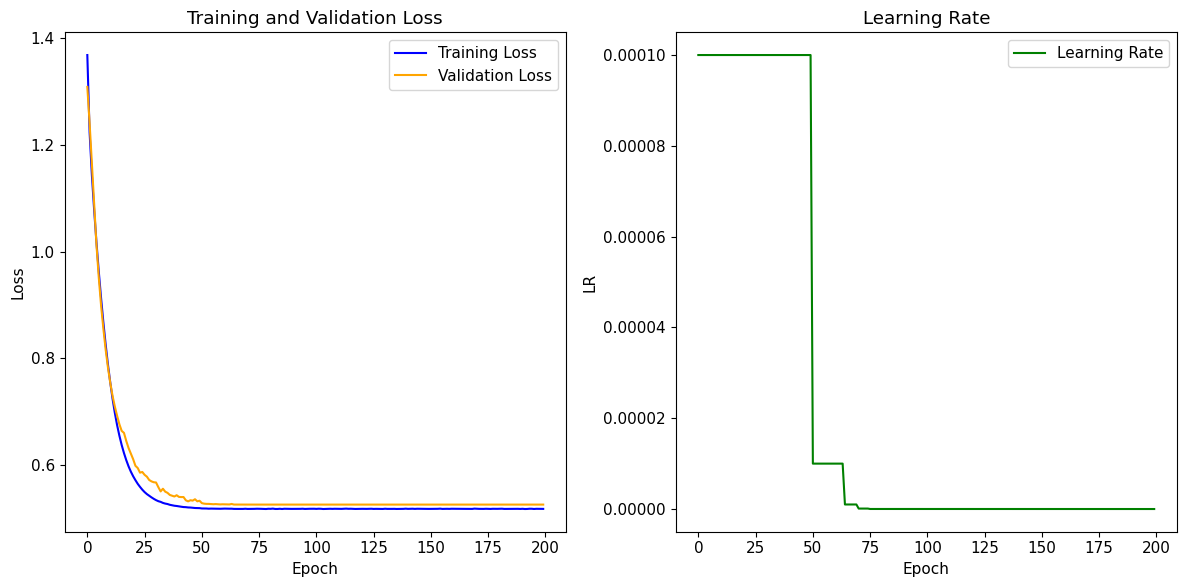

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# Assuming `history` contains your training history object

# Plotting the training and validation loss curves along with learning rate
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot learning rate
plt.subplot(1, 2, 2)
plt.plot(history.history['lr'], label='Learning Rate', color='green')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend()

plt.tight_layout()
plt.show()


#Extra credit (10 points)
Extra credit: if you want to maximize the possibility of developing something new think about how a video can be better segmented into representative frames. For example, in this ~3min video accessed Nov 2023 you have multiple scenes each one lasting 30sec or so. Can you find a way to segment each video and store the frame embeddings of each segment? This way there are multiple embeddings per video and you need to keep them that way for the subsequesnt steps of this project.

#according to professor's suggestion I followed this research paper to integrate their methods "https://arxiv.org/pdf/2205.05487"

#Scene Boundary Detection
The objective of this documentation is to outline the process of detecting scene boundaries in three videos using frame analysis techniques.

#Video Preprocessing:
Extract Frames: Each video was preprocessed to extract frames using OpenCV.

In [64]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import random

def preprocess_video_with_augmentation(video_path, output_dir, num_frames=32, resize=(224, 224)):
    """
    Preprocess a video: decode frames, sample frames, apply augmentations, resize, scale, normalize, and save as .npy.

    Args:
    - video_path (str): Path to the input video file.
    - output_dir (str): Directory to save processed frames.
    - num_frames (int): Number of frames to sample from the video.
    - resize (tuple): Target size for resizing frames (width, height).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    frames = []
    for idx in tqdm(frame_indices, desc=f"Processing {os.path.basename(video_path)}"):
      cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
      ret, frame = cap.read()
      if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Data augmentation
        if random.random() > 0.5:
            frame = cv2.flip(frame, 1)  # Horizontal flip
        if random.random() > 0.5:
            frame = cv2.GaussianBlur(frame, (5, 5), 0)  # Gaussian blur

        frame = cv2.resize(frame, resize)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
      else:
        print(f"Warning: Could not read frame at index {idx} from video {video_path}")


    cap.release()

    if len(frames) < num_frames:
        print(f"Warning: Not enough frames were read from {video_path}. Expected {num_frames}, got {len(frames)}.")

    frames = np.stack(frames) if frames else np.empty((0, *resize, 3))
    output_filename = os.path.join(output_dir, f"{os.path.basename(video_path)}.npy")
    np.save(output_filename, frames)
    print(f"Processed frames saved to {output_filename}")

    return frames

# List of video paths
video_paths = [
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4",
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4"
]

output_dir = '/content/processed_frames'
for video_path in video_paths:
    preprocess_video_with_augmentation(video_path, output_dir)


Processing Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 56.96it/s]


Processed frames saved to /content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy


Processing How Green Roofs Can Help Cities | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 63.93it/s]


Processed frames saved to /content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy


Processing What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4: 100%|██████████| 32/32 [00:00<00:00, 56.13it/s]

Processed frames saved to /content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy


#Load frames

In [65]:
import numpy as np

# Paths to processed frames
frame_paths = [
    "/content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy",
    "/content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy",
    "/content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy"
]

# Load frames
frames_list = [np.load(path) for path in frame_paths]


#Siamese Self-Supervised Learning (SSL)

The code provided sets up a Siamese Self-Supervised Learning (SSL) framework using a ResNet50 base model for video frame embeddings. Initially, video frames are preprocessed and organized into pairs to train the SSL model. The pairs are constructed from consecutive frames within each video. The SSL model architecture includes two parallel branches sharing weights through a ResNet50 backbone, followed by normalization of embeddings and cosine similarity computation between them. Training utilizes a contrastive loss function, defined to penalize the distance between similar pairs and enforce a margin between dissimilar ones. This setup optimizes the SSL model to learn representations where frames from the same video are closer in the embedding space compared to frames from different videos. Training proceeds over multiple epochs with an Adam optimizer, aiming to improve the quality of learned embeddings for downstream tasks like scene boundary detection in videos.

In [66]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np

# Assuming frames_list and frames are defined as in your previous code

def create_ssl_model(input_shape):
    base_cnn = tf.keras.applications.ResNet50(
        weights="imagenet", input_shape=input_shape, include_top=False, pooling='avg'
    )

    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    features_1 = base_cnn(input_1)
    features_2 = base_cnn(input_2)

    l2_normalize = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    features_1_normalized = l2_normalize(features_1)
    features_2_normalized = l2_normalize(features_2)

    cosine_similarity = layers.Dot(axes=1, normalize=True)([features_1_normalized, features_2_normalized])
    ssl_model = Model(inputs=[input_1, input_2], outputs=cosine_similarity)

    return ssl_model

# Assuming frames_list is defined as in your previous code
frames_list = [
    np.load("/content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy"),
    np.load("/content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy"),
    np.load("/content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy")
]

input_shape = (224, 224, 3)
ssl_model = create_ssl_model(input_shape)

# Prepare pairs of augmented frames
def prepare_ssl_pairs(frames):
    pairs = []
    for i in range(len(frames) - 1):
        pairs.append((frames[i], frames[i+1]))
    return pairs

# Create SSL pairs for each video
ssl_pairs_list = [prepare_ssl_pairs(frames) for frames in frames_list]

# Flatten the list of lists
ssl_pairs = [pair for pairs_list in ssl_pairs_list for pair in pairs_list]
x1, x2 = zip(*ssl_pairs)
x1 = np.array(x1)
x2 = np.array(x2)

# Labels for contrastive loss (1 for similar pairs, 0 for dissimilar pairs)
y = np.ones(len(x1))

# Train SSL model with contrastive loss
margin = 1.0  # Margin parameter for contrastive loss
optimizer = tf.keras.optimizers.Adam()

def contrastive_loss(y_true, y_pred):
    squared_pred = tf.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)

ssl_model.compile(optimizer=optimizer, loss=contrastive_loss)

# Train the SSL model
ssl_model.fit([x1, x2], y, batch_size=32, epochs=50)


Epoch 1/50
3/3 [==============================] - 34s 326ms/step - loss: 0.2038
Epoch 2/50
3/3 [==============================] - 1s 328ms/step - loss: 0.0272
Epoch 3/50
3/3 [==============================] - 1s 328ms/step - loss: 0.0103
Epoch 4/50
3/3 [==============================] - 1s 326ms/step - loss: 0.0035
Epoch 5/50
3/3 [==============================] - 1s 326ms/step - loss: 0.0017
Epoch 6/50
3/3 [==============================] - 1s 327ms/step - loss: 0.0013
Epoch 7/50
3/3 [==============================] - 1s 326ms/step - loss: 4.3593e-04
Epoch 8/50
3/3 [==============================] - 1s 328ms/step - loss: 5.0219e-04
Epoch 9/50
3/3 [==============================] - 1s 328ms/step - loss: 1.8836e-04
Epoch 10/50
3/3 [==============================] - 1s 327ms/step - loss: 2.6093e-04
Epoch 11/50
3/3 [==============================] - 1s 327ms/step - loss: 6.1723e-04
Epoch 12/50
3/3 [==============================] - 1s 328ms/step - loss: 1.0027e-04
Epoch 13/50
3/3 [=======

#Scene Boundary Detection:

After completing the Siamese Self-Supervised Learning (SSL) framework, the next step involves using the learned embeddings for downstream tasks, such as detecting scene boundaries in the videos.

Preprocessing Frames: Frames from each video are loaded and resized to match the input shape required by the SSL model.

Extracting Features: The preprocessed frames are passed through the SSL model to extract embeddings (features). These embeddings capture the semantic information learned by the SSL model.

Calculating Differences: For each video, differences between consecutive embeddings (features) are computed using Euclidean norm. This step quantifies how much the content changes from one frame to the next.

Normalizing and Thresholding: The computed differences are normalized and then compared against a threshold to detect significant changes. Scene boundaries are identified where the normalized differences exceed this threshold.

Detecting Scene Boundaries: Finally, scene boundaries are detected based on the normalized differences, and the results are printed for each video.





In [67]:
import numpy as np
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

# Function to preprocess frames to ensure consistent shape
def preprocess_frames(frames, input_shape):
    return np.array([cv2.resize(frame, (input_shape[0], input_shape[1])) for frame in frames])

# Load your processed frames
frames_list = [
    np.load("/content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy"),
    np.load("/content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy"),
    np.load("/content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy")
]

input_shape = (224, 224, 3)  # Input shape for the SSL model
preprocessed_frames_list = [preprocess_frames(frames, input_shape) for frames in frames_list]

# Convert list of arrays into a single array for batch processing
all_frames = np.vstack(preprocessed_frames_list)

# Function to extract features using SSL model
@tf.function
def extract_features(frames, ssl_model):
    base_model = Model(ssl_model.input[0], ssl_model.layers[-2].output)  # Get the model up to the last shared layer
    features = base_model(frames, training=False)  # Use base_model to get features
    return features

# Extract features in batch
features = extract_features(all_frames, ssl_model)

In [68]:
# Split the features back into the original video segments
num_frames_per_video = [frames.shape[0] for frames in frames_list]
split_indices = np.cumsum(num_frames_per_video)[:-1]
features_list = np.split(features, split_indices)


In [69]:
def calculate_differences(features):
    differences = np.linalg.norm(np.diff(features, axis=0), axis=1)
    return differences

def normalize_and_threshold(differences, threshold_factor=1.0):
    norm_differences = (differences - np.mean(differences)) / np.std(differences)
    threshold = threshold_factor * np.mean(norm_differences)
    scene_boundaries = np.where(norm_differences > threshold)[0] + 1  # Adding 1 to get the boundary index
    return scene_boundaries

def detect_scene_boundaries(features_list, threshold_factor=1.0):
    all_scene_boundaries = []
    for features in features_list:
        differences = calculate_differences(features)
        scene_boundaries = normalize_and_threshold(differences, threshold_factor)
        all_scene_boundaries.append(scene_boundaries)
    return all_scene_boundaries

# Calculate and detect scene boundaries for each video
all_scene_boundaries = detect_scene_boundaries(features_list, threshold_factor=1.5)

# Print detected scene boundaries
for i, boundaries in enumerate(all_scene_boundaries):
    print(f"Detected scene boundaries for video {i}: {boundaries}")

Detected scene boundaries for video 0: [ 1  9 11 12 13 14 19 20 21 22 29 31]
Detected scene boundaries for video 1: [ 2  7 11 14 15 16 19 26 30 31]
Detected scene boundaries for video 2: [ 6  7 10 11 17 18 19 22 28 29 31]


#Result Analysis:
The detected scene boundaries were interpreted to highlight key insights such as frequency of scene changes, clustered changes, and scene lengths.

#Step 4: Extract Embeddings(sample embedding)
The embedding used here is the encoded representation of the input image obtained from the encoder part of the autoencoder model.

sample_embedding is obtained by passing a sample input (cropped_objects[:1]) through the encoder. It outputs a compressed representation (embedding) of the input image.

In [70]:
encoder = keras.Model(input_img, encoded)

# Example of extracting embeddings
sample_embedding = encoder.predict(cropped_objects[:1])
print("Embedding shape:", sample_embedding.shape)

print("Embedding size:", sample_embedding.size)

1/1 [==============================] - 0s 92ms/step
Embedding shape: (1, 8, 8, 8)
Embedding size: 512


#Indexing the embeddings (20 points)
Use docker compose to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

docker pull postgres:latest

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure: [vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector, optional]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use this guide.

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.

#Process the detected object sub-images including the vectors (embeddings) for each detected object in the structure:

Extract sub-images for each detected object.
Use the autoencoder to generate embeddings for each sub-image.
Append these embeddings to my results.

In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from datetime import timedelta
import logging
from keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Define autoencoder model
input_img = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
adam_optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=adam_optimizer, loss='binary_crossentropy')
encoder = Model(input_img, encoded)

# Function to extract and preprocess sub-images
def preprocess_sub_image(frame, bbox, size=(64, 64)):
    xmin, ymin, xmax, ymax = map(int, bbox)
    sub_img = frame[ymin:ymax, xmin:xmax]
    sub_img = cv2.resize(sub_img, size)
    sub_img = sub_img.astype(np.float32) / 255.0
    return sub_img

# Process each video and extract embeddings
video_paths = [
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
]

results = []

for vidId, video_path in enumerate(video_paths):
    logging.info(f"Processing video {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Error: Could not open video {video_path}")
        continue

    frame_num = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logging.info(f"Total frames: {total_frames}, FPS: {fps}")

    frame_interval = 10  # Process every 10th frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % frame_interval == 0:
            logging.info(f"Processing frame {frame_num}/{total_frames}")
            timestamp = str(timedelta(seconds=frame_num / fps))

            results_yolo = model(frame)
            detections = results_yolo.pandas().xyxy[0]

            for _, detection in detections.iterrows():
                detectedObjId = detection['class']
                detectedObjClass = detection['name']
                confidence = detection['confidence']
                bbox_info = [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']]

                sub_image = preprocess_sub_image(frame, bbox_info)
                sub_image = np.expand_dims(sub_image, axis=0)
                embedding = encoder.predict(sub_image).flatten()

                results.append([
                    vidId, frame_num, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, embedding.tolist()
                ])

                # Print embedding shape and size
                print(f"Embedding shape: {embedding.shape}")
                print(f"Embedding size: {embedding.size}")

        frame_num += 1

    cap.release()
    logging.info(f"Finished processing video {video_path}")

# Save results to CSV
df = pd.DataFrame(results, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox_info', 'vector'])
df.to_csv('detection_results_with_embeddings.csv', index=False)
logging.info("Detection results with embeddings saved to detection_results_with_embeddings.csv")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-21 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Streaming output truncated to the last 5000 lines.
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 20ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 21ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 23ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 21ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('detection_results_with_embeddings.csv')

# Print the head of the DataFrame
print(df.head())

   vidId  frameNum       timestamp  detectedObjId detectedObjClass  \
0      0       120  0:00:05.005000              0           person   
1      0       120  0:00:05.005000              0           person   
2      0       120  0:00:05.005000              0           person   
3      0       120  0:00:05.005000              0           person   
4      0       120  0:00:05.005000              0           person   

   confidence                                          bbox_info  \
0    0.865962  [1.8373260498046875, 215.29153442382812, 165.1...   
1    0.846955  [234.6238555908203, 265.1407470703125, 293.524...   
2    0.819844  [345.802490234375, 272.62176513671875, 424.704...   
3    0.766788  [408.46807861328125, 192.9556121826172, 618.45...   
4    0.744017  [417.0980224609375, 255.2174072265625, 464.637...   

                                              vector  
0  [0.0878366008400917, 0.045856595039367676, 0.0...  
1  [0.03064996562898159, 0.015085775405168533, 0....  
2  [0

#Result Analysis
**The output Embedding shape: (512,)** indicates that each embedding is a 1-dimensional array (vector) with 512 elements. **The size of the embedding, which is also 512**, corresponds to the total number of elements in the array.

This means that for each detected object in the videos, **the autoencoder produces an embedding that is represented as a vector with 512 values, capturing the encoded representation of the corresponding sub-image of the detected object.**

df will include all the detection results along with embeddings for each detected object in the videos. Each row in df represents one detection instance (one object detected in one frame of one video), with the corresponding embedding vector included.

#postgresql with pgvector extension

In [ ]:
!apt update
!apt install postgresql postgresql-contrib
!pip install psycopg2-binary


In [ ]:
!service postgresql start
!sudo -u postgres psql -c "CREATE DATABASE mydatabase;"


 * Starting PostgreSQL 14 database server
   ...done.
CREATE DATABASE


In [ ]:
# Install required packages for compiling pgvector
!apt-get -qq install build-essential postgresql-server-dev-all
!git clone https://github.com/ankane/pgvector.git
%cd pgvector
!make
!make install

In [ ]:
import pgvector
print("pgvector imported successfully!")

pgvector imported successfully!


In [ ]:
%cd pgvector
!ls

[Errno 2] No such file or directory: 'pgvector'
/content/pgvector
CHANGELOG.md  LICENSE	Makefile.win  README.md  src   vector.control
Dockerfile    Makefile	META.json     sql	 test  vector.so


In [ ]:
!sudo -u postgres psql -c "ALTER USER postgres WITH PASSWORD 'postgres';"


ALTER ROLE


In [ ]:
# Create a new role 'root' with superuser privileges
!sudo -u postgres psql -U postgres -c "CREATE ROLE root WITH SUPERUSER;"

CREATE ROLE


In [ ]:
import psycopg2
import os

# Replace placeholders with your actual connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
# Retrieve password from environment variable
password = "postgres"

try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Proceed with your database operations...

    # Close connection
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!


#index video images' embedding vectors in a PostgreSQL database using the pgvector extension

In [ ]:
import psycopg2

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    cur = conn.cursor()

    # Create the pgvector extension
    cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
    conn.commit()
    print("pgvector extension created successfully!")

    # Create table with pgvector extension
    cur.execute("""
    CREATE TABLE IF NOT EXISTS video_embeddings (
        vidId INT,
        frameNum INT,
        timestamp TEXT,
        detectedObjId INT,
        detectedObjClass TEXT,
        confidence FLOAT,
        bbox_info TEXT,
        vector vector(512)  -- Assuming embedding size of 512
    );
    """)

    conn.commit()
    print("Table created successfully!")

    cur.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!
pgvector extension created successfully!
Table created successfully!


In [ ]:
import psycopg2
import pandas as pd
import ast

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    cur = conn.cursor()

    # Load CSV data from the correct path in Google Colab
    csv_file_path = '/content/detection_results_with_embeddings.csv'
    df = pd.read_csv(csv_file_path)

    # Insert data into the table
    for _, row in df.iterrows():
        vector = ast.literal_eval(row['vector'])  # Convert string to list
        cur.execute("""
        INSERT INTO video_embeddings (vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
        """, (row['vidId'], row['frameNum'], row['timestamp'], row['detectedObjId'], row['detectedObjClass'], row['confidence'], row['bbox_info'], vector))

    conn.commit()
    print("Data inserted successfully!")

    cur.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!
Data inserted successfully!


In [ ]:
import psycopg2
from psycopg2.extras import DictCursor

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Create a cursor to execute SQL queries
    with conn.cursor(cursor_factory=DictCursor) as cur:
        # Your indexing SQL command here
        index_query = """
        CREATE INDEX video_embeddings_vector_idx ON video_embeddings USING ivfflat(vector);
        """
        cur.execute(index_query)
        print("Indexing complete.")

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


Successfully connected to PostgreSQL!
Indexing complete.
Connection closed.


In [ ]:
import psycopg2
from tabulate import tabulate  # This is optional, for pretty printing

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Create a cursor object using the connection
    cur = conn.cursor()

    # Query to fetch first 10 rows from video_embeddings table
    cur.execute("SELECT * FROM video_embeddings LIMIT 10;")

    # Fetch all rows
    rows = cur.fetchall()

    # Print the rows using tabulate for better formatting (optional)
    headers = [desc[0] for desc in cur.description]
    print(tabulate(rows, headers=headers, tablefmt="psql"))

    # Close cursor and connection
    cur.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.

In [ ]:
import psycopg2

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password
)
print("Successfully connected to PostgreSQL!")


Successfully connected to PostgreSQL!


In [ ]:
import psycopg2
from psycopg2.extras import DictCursor

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"


# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Query to fetch vectors and metadata for exploration
    query = """
    SELECT vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector
    FROM video_embeddings
    LIMIT 10;  -- Adjust to fetch more or fewer records for exploration
    """

    with conn.cursor(cursor_factory=DictCursor) as cur:
        cur.execute(query)
        rows = cur.fetchall()

        for row in rows:
            # Use direct column names or specify aliases as per your actual column names
            vidId = row['vidid']  # Ensure 'vidid' matches the actual column name from PostgreSQL
            frameNum = row['framenum']
            timestamp = row['timestamp']
            detectedObjId = row['detectedobjid']
            detectedObjClass = row['detectedobjclass']
            confidence = row['confidence']
            bbox_info = row['bbox_info']
            vector = row['vector']

            # Print or analyze metadata and vector structure
            print(f"vidId: {vidId}, frameNum: {frameNum}, timestamp: {timestamp}")
            print(f"Detected Object: ID={detectedObjId}, Class={detectedObjClass}, Confidence={confidence}")
            print(f"Bbox Info: {bbox_info}")
            print(f"Vector: {vector}")
            print(f"Vector Length: {len(vector)}")  # Check vector length

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


Successfully connected to PostgreSQL!
Loading frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 130 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 130 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 140 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 140 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 150 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 150 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 160 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4


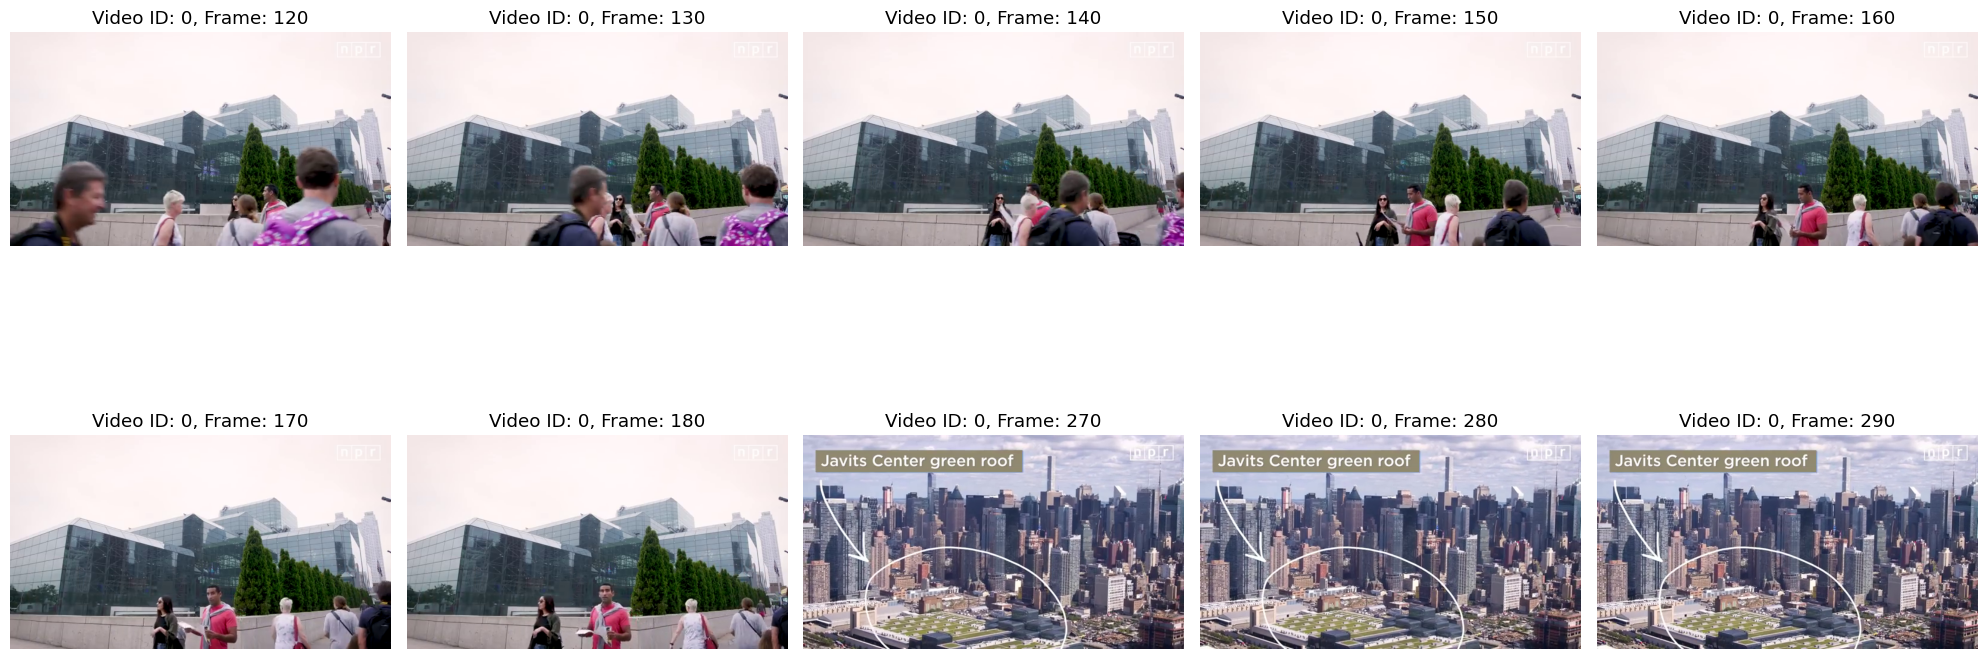

Connection closed.


In [ ]:
import pandas as pd
import ast
import psycopg2
import matplotlib.pyplot as plt
import cv2

# Function to load a specific frame from a video file
def load_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        print(f"Failed to load frame {frame_num} from {video_path}")
        return None

# Load the CSV file containing the embeddings
df = pd.read_csv('/content/detection_results_with_embeddings.csv')

# Select a query vector (example: first row)
query_vector = df.iloc[0]['vector']

# Convert the string representation of the list to an actual list
query_vector = ast.literal_eval(query_vector)

# Convert the list of floats to a PostgreSQL array string with brackets
query_vector_str = '[' + ','.join(map(str, query_vector)) + ']'

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Construct the search query with DISTINCT ON clause
search_query = f"""
SELECT DISTINCT ON (vidId, frameNum) vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector,
       vector <-> '{query_vector_str}'::vector AS distance
FROM video_embeddings
ORDER BY vidId, frameNum, distance ASC
LIMIT 10;
"""

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Execute the search query
    with conn.cursor() as cur:
        cur.execute(search_query)
        rows = cur.fetchall()

        # Convert result to DataFrame for better visualization (optional)
        columns = ['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass',
                   'confidence', 'bbox_info', 'vector', 'distance']
        df_results = pd.DataFrame(rows, columns=columns)

        # Display the first 10 similar images
        video_paths = [
            "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
            "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
            "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
        ]

        plt.figure(figsize=(20, 10))
        for i, row in df_results.iterrows():
            if i >= 10:  # Display only the first 10 similar images
                break

            vidId = row['vidId']
            frameNum = row['frameNum']
            video_path = video_paths[vidId]

            print(f"Loading frame {frameNum} from video {video_path}")
            frame = load_frame(video_path, frameNum)

            if frame is not None:
                print(f"Frame {frameNum} from video {video_path} loaded successfully with shape: {frame.shape}")
                plt.subplot(2, 5, i+1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Video ID: {vidId}, Frame: {frameNum}")
                plt.axis('off')
            else:
                print(f"Failed to display frame {frameNum} from video {video_path}")

        plt.tight_layout()
        plt.show()

except psycopg2.Error as e:
    print(f"Error executing query: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


Successfully connected to PostgreSQL!
Loading frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 2300 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
Frame 2300 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4 loaded successfully with shape: (360, 480, 3)
Loading frame 2310 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
Frame 2310 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4 loaded successfully with shape: (360, 480, 3)
Loading frame 860 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 860 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 2320 from vi

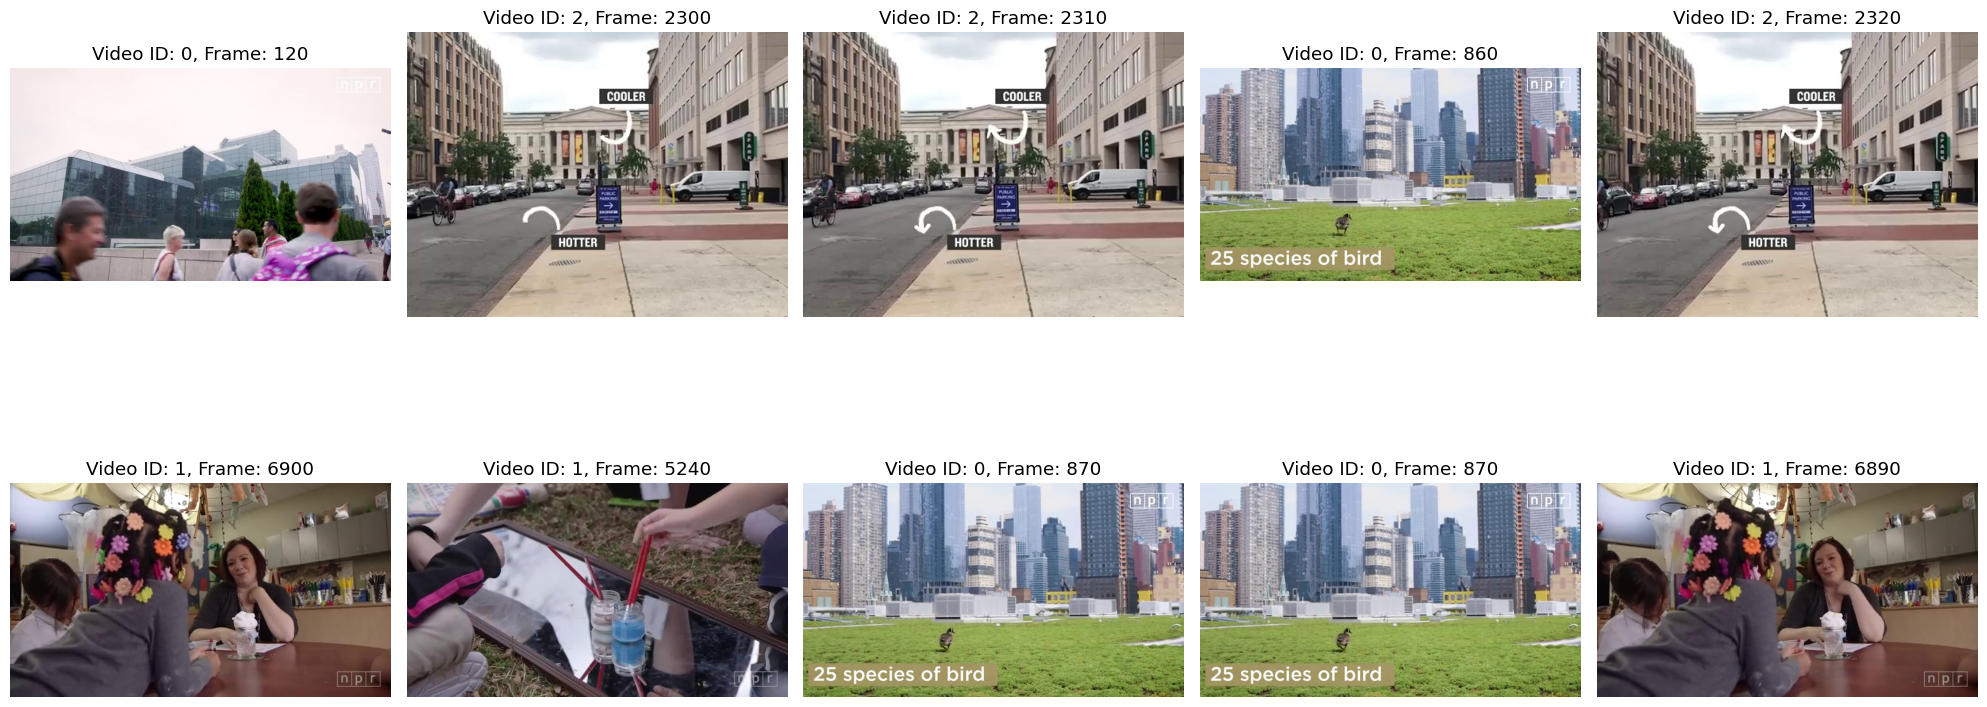

Connection closed.


In [ ]:
import psycopg2
import pandas as pd
import ast
import matplotlib.pyplot as plt
import cv2

# Function to load a specific frame from a video file
def load_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        print(f"Failed to load frame {frame_num} from {video_path}")
        return None

# Load the CSV file containing the embeddings
df = pd.read_csv('/content/detection_results_with_embeddings.csv')

# Select a query vector (example: first row)
query_vector = df.iloc[0]['vector']

# Convert the string representation of the list to an actual list
query_vector = ast.literal_eval(query_vector)

# Convert the list of floats to a PostgreSQL array string with brackets
query_vector_str = '[' + ','.join(map(str, query_vector)) + ']'

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Construct the search query
search_query = f"""
SELECT vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector,
       vector <-> '{query_vector_str}'::vector AS distance
FROM video_embeddings
ORDER BY distance ASC
LIMIT 10;
"""

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Execute the search query
    with conn.cursor() as cur:
        cur.execute(search_query)
        rows = cur.fetchall()

        # Convert result to DataFrame for better visualization (optional)
        columns = ['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass',
                   'confidence', 'bbox_info', 'vector', 'distance']
        df_results = pd.DataFrame(rows, columns=columns)

        # Display the first 10 similar images
        video_paths = [
            "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
            "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
            "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
        ]

        plt.figure(figsize=(20, 10))
        for i, row in df_results.iterrows():
            if i >= 10:  # Display only the first 10 similar images
                break

            vidId = row['vidId']
            frameNum = row['frameNum']
            video_path = video_paths[vidId]

            print(f"Loading frame {frameNum} from video {video_path}")
            frame = load_frame(video_path, frameNum)

            if frame is not None:
                print(f"Frame {frameNum} from video {video_path} loaded successfully with shape: {frame.shape}")
                plt.subplot(2, 5, i+1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Video ID: {vidId}, Frame: {frameNum}")
                plt.axis('off')
            else:
                print(f"Failed to display frame {frameNum} from video {video_path}")

        plt.tight_layout()
        plt.show()

except psycopg2.Error as e:
    print(f"Error executing query: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


In [ ]:
import psycopg2

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password
)
print("Successfully connected to PostgreSQL!")

# Execute the SQL command to install the cube extension
try:
    with conn.cursor() as cur:
        cur.execute("CREATE EXTENSION IF NOT EXISTS cube;")
    conn.commit()
    print("cube extension installed successfully.")
except psycopg2.Error as e:
    print(f"Error installing cube extension: {e}")
finally:
    conn.close()
    print("Connection closed.")


Successfully connected to PostgreSQL!
cube extension installed successfully.
Connection closed.


Successfully connected to PostgreSQL!
Loading frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 840 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
Frame 840 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4 loaded successfully with shape: (360, 480, 3)
Loading frame 6900 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4
Frame 6900 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 810 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4
Frame 810 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4 loaded successfully with shape: (360

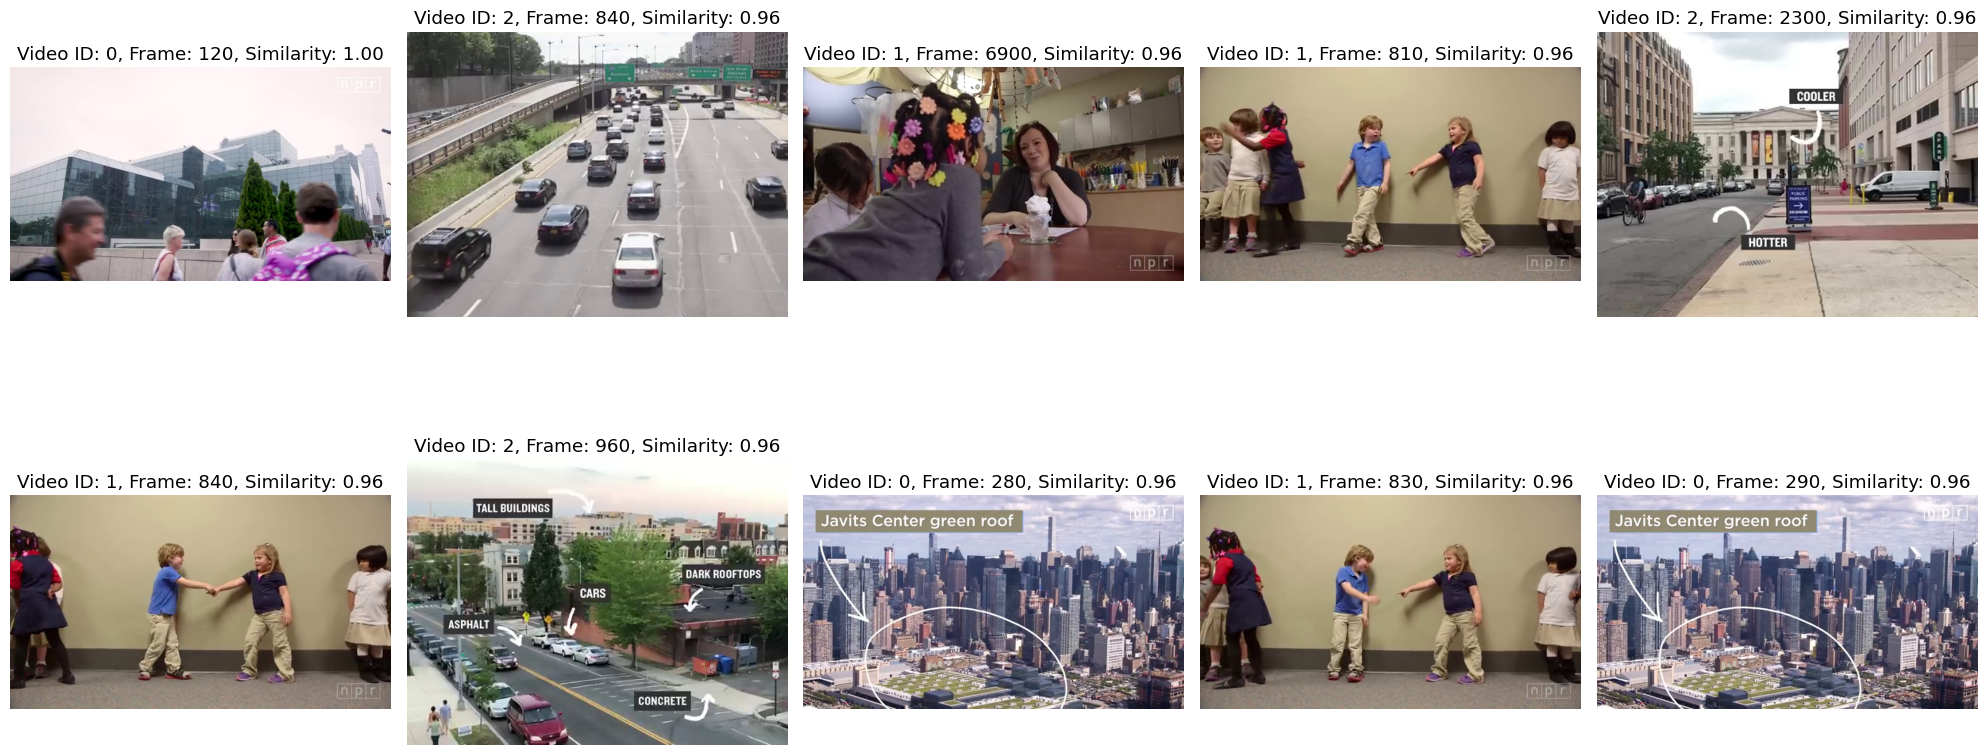

Connection closed.


In [ ]:
import psycopg2
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

# Function to load a specific frame from a video
def load_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        print(f"Failed to load frame {frame_num} from {video_path}")
        return None

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Fetch all vectors from the database
    with conn.cursor() as cur:
        cur.execute("SELECT vidId, frameNum, vector FROM video_embeddings;")
        rows = cur.fetchall()

    # Convert result to DataFrame for better manipulation (optional)
    columns = ['vidId', 'frameNum', 'vector']
    df_embeddings = pd.DataFrame(rows, columns=columns)

    # Select a query vector (example: first row)
    query_vector = df_embeddings.iloc[0]['vector']

    # Convert the string representation of the list to an actual list
    query_vector = ast.literal_eval(query_vector)

    # Convert to numpy array for easier computation
    query_vector = np.array(query_vector).reshape(1, -1)  # Reshape to a row vector

    # Compute cosine similarity for all vectors
    vectors = np.array([ast.literal_eval(v) for v in df_embeddings['vector']])
    similarities = cosine_similarity(query_vector, vectors)

    # Add similarities to DataFrame
    df_embeddings['similarity'] = similarities[0]

    # Sort by similarity and get top 10 similar images
    df_results = df_embeddings.sort_values(by='similarity', ascending=False).head(10)

    # Display the first 10 similar images
    video_paths = [
        "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
        "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
        "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
    ]

    plt.figure(figsize=(20, 10))
    for i in range(min(10, len(df_results))):  # Limit to first 10 frames or less if fewer are available
        row = df_results.iloc[i]
        vidId = row['vidId']
        frameNum = row['frameNum']
        video_path = video_paths[vidId]

        print(f"Loading frame {frameNum} from video {video_path}")
        frame = load_frame(video_path, frameNum)

        if frame is not None:
            print(f"Frame {frameNum} from video {video_path} loaded successfully with shape: {frame.shape}")
            plt.subplot(2, 5, i+1)  # Adjust subplot index to match 2x5 grid
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Video ID: {vidId}, Frame: {frameNum}, Similarity: {row['similarity']:.2f}")
            plt.axis('off')
        else:
            print(f"Failed to display frame {frameNum} from video {video_path}")

    plt.tight_layout()
    plt.show()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")
